### 1. The first Part of this code try with one image to test the download of the image in drive

In [ ]:
!pip install earthengine-api #earth-engine Python API

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 6.9 MB/s 
     |████████████████████████████████| 16.7 MB 328 kB/s 
     |████████████████████████████████| 6.3 MB 45.5 MB/s 


In [ ]:
!earthengine authenticate 

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=bVg3IFNM6sW3VYwfX45qEhymu3ear0pEo7zspajBmmk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiqSTFHG3wGhr6nAIOYCLJJF2NJSAGI76vNP_E1ZRuZ9aeRTwgtQdM

Successfully saved authorization token.


In [ ]:
!pip install geetools

     |████████████████████████████████| 74 kB 2.8 MB/s 
     |████████████████████████████████| 44 kB 3.7 MB/s 
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92107 sha256=2a49e39658fb0c26995d7974a7fe339bf754f4a4ecee2c8e30438cf7f1c0e690
  Stored in directory: /root/.cache/pip/wheels/5c/55/29/0a09dcf6b39bba8c890e40171cac3e3607a5c4b354b7e9447c
Successfully built geetools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import ee 
import folium
import geetools
import pandas as pd
from geopandas import GeoSeries
from shapely.geometry import Polygon

In [ ]:
def coord(text):
    x = text.split(" ")[1][1:]
    y = text.split(" ")[2][:len(text.split(" ")[2])-1] 
    x = float(x)
    y = float(y)
    side = 0.1
    square = [x-side/2, y+side/2, x+side/2, y-side/2]
    return square

In [ ]:
# Earth Engine Python API
ee.Initialize()

In [ ]:
# Read the dataset 
data=pd.read_csv('/content/drive/MyDrive/Classroom/21DM008 Analysis of Spatial Data and Images 21-22 DSDM T2/project/data_final.csv')


In [ ]:
square_point=coord(data['geometry'][0])

In [ ]:
#load image
geometry = ee.Geometry.Rectangle(square_point)
img_Collection = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
img_Collection= img_Collection.filter(ee.Filter.eq('instrumentMode', 'IW')).select('VV')

In [ ]:
desc=img_Collection.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
asc=img_Collection.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))



In [ ]:
spring = ee.Filter.date('2014-10-01', '2014-11-01');
lateSpring = ee.Filter.date('2014-11-01', '2014-12-01');
summer = ee.Filter.date('2014-12-01', '2015-01-01');

In [ ]:
descChange = ee.Image.cat(
        desc.filter(spring).mean(),
        desc.filter(lateSpring).mean(),
        desc.filter(summer).mean())

In [ ]:
ascChange = ee.Image.cat(
        asc.filter(spring).mean(),
        asc.filter(lateSpring).mean(),
        asc.filter(summer).mean())

In [ ]:
my_Image_desc=descChange.clip(geometry)
my_Image_desc=ascChange.clip(geometry)

In [ ]:
task=geetools.batch.Export.image.toDrive(
    image=my_Image_desc, 
    description='test_2',
    folder='spatial_4',
    scale=30
)
task.start()

In [ ]:
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).
Polling for task (id: T2234LB3Z2JVC6O6XSL7EDR4).


In [ ]:
!pip install rasterio

In [ ]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
import rasterio

In [ ]:
# import the TIFF 
tiff = rasterio.open('/content/drive/MyDrive/spatial_final_r/image_70.tif')

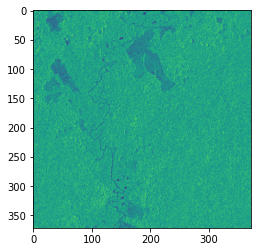

In [ ]:
plt.imshow(tiff.read(1))

In [ ]:
### Recive a collection of images and clip it to the square, download the square to google drive 
def image_download(collection,square,index,folder_p):
  geometry = ee.Geometry.Rectangle(square)
  my_Image_desc=collection.clip(geometry)
  task=geetools.batch.Export.image.toDrive(
    image=my_Image_desc, 
    description='image_'+str(index),
    folder=folder_p,
    scale=30)
  task.start()
  while task.active():
    pass
  print('image_'+str(index)+' saved.')

def download_batch(start_index,end_index,data,folder): 
  for i in range (start_index,end_index+1):
    square_point=coord(data['geometry'][i])
    img_Collection = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    img_Collection= img_Collection.filter(ee.Filter.eq('instrumentMode', 'IW')).select('VV')
    desc=img_Collection.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    spring = ee.Filter.date('2014-10-01', '2014-11-01');
    lateSpring = ee.Filter.date('2014-11-01', '2014-12-01');
    summer = ee.Filter.date('2014-12-01', '2015-01-01');
    descChange = ee.Image.cat(
    desc.filter(spring).mean(),
    desc.filter(lateSpring).mean(),
    desc.filter(summer).mean())
    image_download(descChange,square_point,i,folder)
  

In [ ]:
### You have to specify 3 parameters 
# the index of the fisrt image you want to download 
# the index of the second image you want to download 
# the dataframe that contains the coca points
# the name of the folder you want to save the images, please dont introduce any /, the folder have to be in the root of the drive. 
download_batch(147,667,data,'spatial_final_r')

image_147 saved.
image_148 saved.
image_149 saved.
image_150 saved.
image_151 saved.
image_152 saved.
image_153 saved.
image_154 saved.
image_155 saved.
image_156 saved.
image_157 saved.
image_158 saved.
image_159 saved.
image_160 saved.
image_161 saved.
image_162 saved.
image_163 saved.
image_164 saved.
image_165 saved.
image_166 saved.
image_167 saved.
image_168 saved.
image_169 saved.
image_170 saved.
image_171 saved.
image_172 saved.
image_173 saved.
image_174 saved.
image_175 saved.
image_176 saved.
image_177 saved.
image_178 saved.
image_179 saved.
image_180 saved.
image_181 saved.
image_182 saved.
image_183 saved.
image_184 saved.
image_185 saved.
image_186 saved.
image_187 saved.
image_188 saved.
image_189 saved.
image_190 saved.
image_191 saved.
image_192 saved.
image_193 saved.
image_194 saved.
image_195 saved.
image_196 saved.
image_197 saved.
image_198 saved.
image_199 saved.
image_200 saved.
image_201 saved.
image_202 saved.
image_203 saved.
image_204 saved.
image_205 save